<a href="https://colab.research.google.com/github/yashveersinghsohi/Hands_On_ML_Book_Practice/blob/master/Chapter_8/HOML_Chapter8_Dimentionality_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Packages

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import (
  fetch_openml, make_swiss_roll, load_digits
)
from sklearn.metrics import mean_squared_error

from sklearn.decomposition import (
  PCA, IncrementalPCA, KernelPCA
)
from sklearn.manifold import (
  LocallyLinearEmbedding, MDS, Isomap, TSNE
)
from sklearn.manifold._locally_linear import barycenter_kneighbors_graph
from sklearn.random_projection import (
  SparseRandomProjection, GaussianRandomProjection
)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# PCA

## Data

In [23]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [24]:
X = mnist["data"]
y = mnist["target"]

## Choosing number of Components

### 1. Run PCA to get all components, and then filter on explained variance (numerically or using plots)

In [ ]:
pca = PCA(
  random_state=42,
  n_components=None,
  svd_solver="full"
)

In [ ]:
pca.fit(X)

PCA(random_state=42, svd_solver='full')

In [ ]:
(np.cumsum(pca.explained_variance_ratio_)<0.95).sum()+1

154

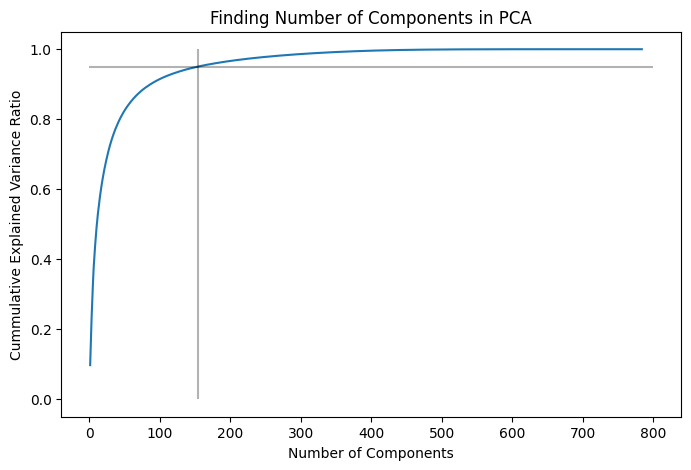

In [ ]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(list(range(1, X.shape[1]+1)), np.cumsum(pca.explained_variance_ratio_))
ax.hlines(y=0.95, xmin=0, xmax=800, color="k", alpha=0.3)
ax.vlines(x=(np.cumsum(pca.explained_variance_ratio_)<0.95).sum()+1, ymin=0, ymax=1, color="k", alpha=0.3)
ax.set(xlabel="Number of Components", ylabel="Cummulative Explained Variance Ratio", title="Finding Number of Components in PCA")
plt.show()

### 2. Mention explained variance in the instantiation of PCA

In [ ]:
pca = PCA(
  random_state=42,
  n_components=0.95,
  svd_solver="full"
)

In [ ]:
pca.fit(X)

PCA(n_components=0.95, random_state=42, svd_solver='full')

In [ ]:
pca.components_.shape

(154, 784)

## Projection & Reconstruction

Reconstruction Error: 217.2172621387621


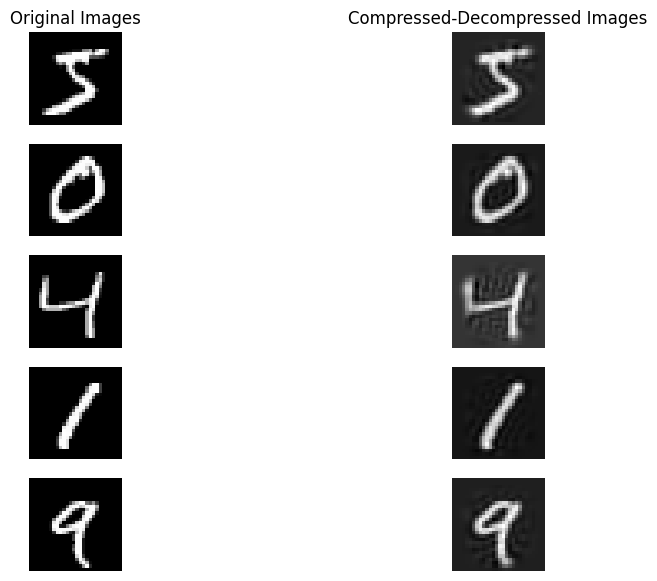

In [ ]:
X_compressed = pca.transform(X)
X_decompressed = pca.inverse_transform(X_compressed)

reconstruction_error = mean_squared_error(y_true=X, y_pred=X_decompressed)
print(f"Reconstruction Error: {reconstruction_error}")

fig, ax = plt.subplots(5, 2, figsize=(10, 7))
for row in range(5):
  ax[row, 0].imshow(X[row].reshape((28, 28)), cmap="gray")
  ax[row, 0].axis("off")

  ax[row, 1].imshow(X_decompressed[row].reshape((28, 28)), cmap="gray")
  ax[row, 1].axis("off")
ax[0, 0].set_title("Original Images")
ax[0, 1].set_title("Compressed-Decompressed Images")
plt.show()

## Randomized PCA

In [ ]:
pca_randomized = PCA(
  random_state=42,
  n_components=153, 
  svd_solver="randomized"
)

In [ ]:
pca_randomized.fit(X)

PCA(n_components=153, random_state=42, svd_solver='randomized')

Reconstruction Error: 220.4050994997899


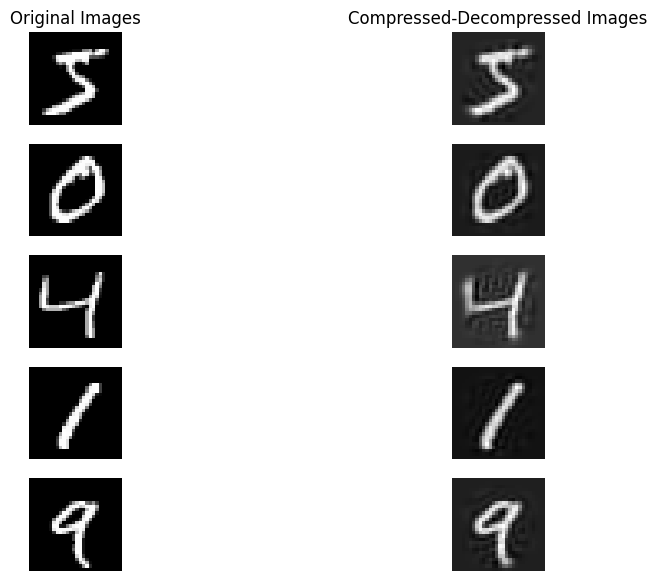

In [ ]:
X_compressed = pca_randomized.transform(X)
X_decompressed = pca_randomized.inverse_transform(X_compressed)

reconstruction_error = mean_squared_error(y_true=X, y_pred=X_decompressed)
print(f"Reconstruction Error: {reconstruction_error}")

fig, ax = plt.subplots(5, 2, figsize=(10, 7))
for row in range(5):
  ax[row, 0].imshow(X[row].reshape((28, 28)), cmap="gray")
  ax[row, 0].axis("off")

  ax[row, 1].imshow(X_decompressed[row].reshape((28, 28)), cmap="gray")
  ax[row, 1].axis("off")
ax[0, 0].set_title("Original Images")
ax[0, 1].set_title("Compressed-Decompressed Images")
plt.show()

## Incremental PCA

In [ ]:
n_batches = 100
batch_size=X.shape[0]//n_batches
inc_pca = IncrementalPCA(n_components=153)
for batch in np.array_split(X, n_batches):
  inc_pca.partial_fit(batch)

Reconstruction Error: 220.73940406381845


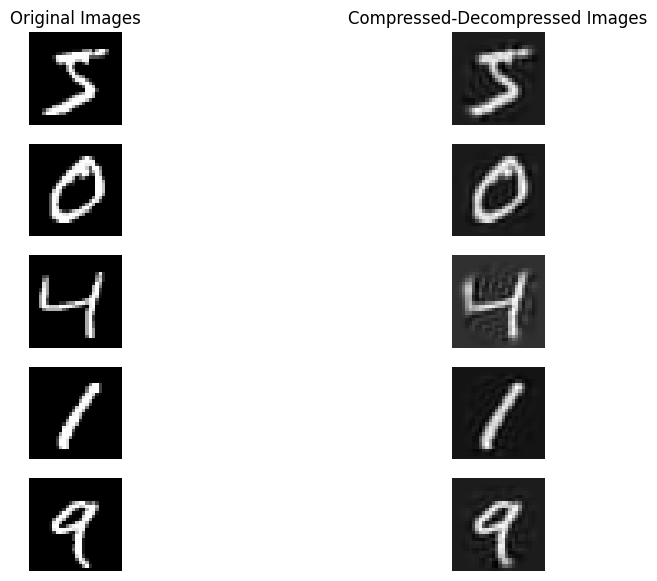

In [ ]:
X_compressed = inc_pca.transform(X)
X_decompressed = inc_pca.inverse_transform(X_compressed)

reconstruction_error = mean_squared_error(y_true=X, y_pred=X_decompressed)
print(f"Reconstruction Error: {reconstruction_error}")

fig, ax = plt.subplots(5, 2, figsize=(10, 7))
for row in range(5):
  ax[row, 0].imshow(X[row].reshape((28, 28)), cmap="gray")
  ax[row, 0].axis("off")

  ax[row, 1].imshow(X_decompressed[row].reshape((28, 28)), cmap="gray")
  ax[row, 1].axis("off")
ax[0, 0].set_title("Original Images")
ax[0, 1].set_title("Compressed-Decompressed Images")
plt.show()

Alternatively we can let numpy split the dataset in from a file stored in disk only (instead of doing it using a dataset stored in a variable as shown above)

In [ ]:
filename = "my_mnist.data"
m, n = X.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X

In [ ]:
del X_mm # Ensures that we are reading from disk next time around

In [ ]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=700, n_components=154)

Reconstruction Error: 218.84796285932023


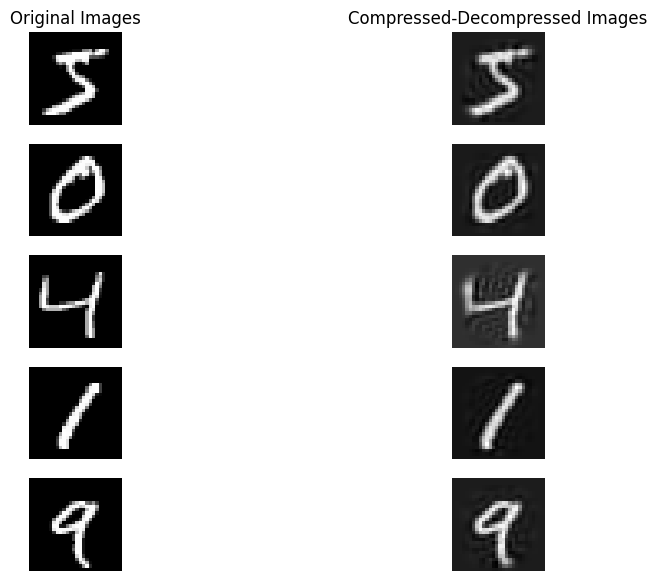

In [ ]:
X_compressed = inc_pca.transform(X)
X_decompressed = inc_pca.inverse_transform(X_compressed)

reconstruction_error = mean_squared_error(y_true=X, y_pred=X_decompressed)
print(f"Reconstruction Error: {reconstruction_error}")

fig, ax = plt.subplots(5, 2, figsize=(10, 7))
for row in range(5):
  ax[row, 0].imshow(X[row].reshape((28, 28)), cmap="gray")
  ax[row, 0].axis("off")

  ax[row, 1].imshow(X_decompressed[row].reshape((28, 28)), cmap="gray")
  ax[row, 1].axis("off")
ax[0, 0].set_title("Original Images")
ax[0, 1].set_title("Compressed-Decompressed Images")
plt.show()

## Kernel PCA (Very unstable - keeps crashing ram for high dimensional datasets)

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [ ]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

X_reduced_lin = lin_pca.fit_transform(X)
X_lin = lin_pca.inverse_transform(X_reduced_lin)

X_reduced_rbf = rbf_pca.fit_transform(X)
X_rbf = lin_pca.inverse_transform(X_reduced_rbf)

X_reduced_sig = sig_pca.fit_transform(X)
X_sig = lin_pca.inverse_transform(X_reduced_sig)

In [ ]:
mean_squared_error(y_true=X, y_pred=X_lin), mean_squared_error(y_true=X, y_pred=X_rbf), mean_squared_error(y_true=X, y_pred=X_sig)

(51.58463490231117, 82.12522280656034, 83.15947193369134)

In [ ]:
# kpca = KernelPCA(
#   random_state=42, 
#   n_components=None, 
#   kernel="rbf", 
#   fit_inverse_transform=True
# )

In [ ]:
# kpca.fit(X)

In [ ]:
# X_compressed = kpca.transform(X)
# X_decompressed = kpca.inverse_transform(X_compressed)

# reconstruction_error = mean_squared_error(y_true=X, y_pred=X_decompressed)
# print(f"Reconstruction Error: {reconstruction_error}")

# fig, ax = plt.subplots(5, 2, figsize=(10, 7))
# for row in range(5):
#   ax[row, 0].imshow(X[row].reshape((28, 28)), cmap="gray")
#   ax[row, 0].axis("off")

#   ax[row, 1].imshow(X_decompressed[row].reshape((28, 28)), cmap="gray")
#   ax[row, 1].axis("off")
# ax[0, 0].set_title("Original Images")
# ax[0, 1].set_title("Compressed-Decompressed Images")
# plt.show()

# Locally Linear Embedding (LLE)

In [ ]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_compressed = lle.fit_transform(X)
# Study this for decompression - https://stackoverflow.com/questions/69123836/inverse-locally-linear-embedding-lle-in-python
# X_decompressed = lle.inverse_transform(X_compressed)
# mean_squared_error(y_true=X, y_pred=X_decompressed)

# Random Projections (Inverse Transformations take a long time to run)

## Gaussian Random Projections

In [ ]:
rng = np.random.RandomState(42)
X = rng.rand(25, 3000)
transformer = GaussianRandomProjection(random_state=rng, compute_inverse_components=True)
X_new = transformer.fit_transform(X)
X_new.shape

(25, 2759)

In [ ]:
mean_squared_error(y_true=X, y_pred=transformer.inverse_transform(X_new))

0.02830439778888998

## Sparse Random Projections

In [ ]:
rng = np.random.RandomState(42)
X = rng.rand(25, 3000)
transformer = SparseRandomProjection(random_state=rng, compute_inverse_components=True)
X_new = transformer.fit_transform(X)
X_new.shape

(25, 2759)

In [ ]:
mean_squared_error(y_true=X, y_pred=transformer.inverse_transform(X_new))

0.028677114051008278

# Multidimensional Scaling (MDS)

## Metric MDS

In [8]:
X, _ = load_digits(return_X_y=True)
X.shape

(1797, 64)

In [9]:
embedding = MDS(n_components=2, metric=True, random_state=42)
X_transformed = embedding.fit_transform(X[:100])
X_transformed.shape

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(100, 2)

## Non-Metric MDS

In [11]:
X, _ = load_digits(return_X_y=True)
X.shape

(1797, 64)

In [12]:
embedding = MDS(n_components=2, metric=False, random_state=42)
X_transformed = embedding.fit_transform(X[:100])
X_transformed.shape

/usr/local/lib/python3.9/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


(100, 2)

# Isomap

In [17]:
X, _ = load_digits(return_X_y=True)
X.shape

(1797, 64)

In [18]:
embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X[:100])
X_transformed.shape

(100, 2)

In [19]:
embedding.reconstruction_error()

2144.99337018528

# t-SNE

In [21]:
X = np.array([[0, 0, 0], [0, 1, 1], [1, 0, 1], [1, 1, 1]])
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(X)
X_embedded.shape

(4, 2)

# LDA

In [25]:
# X, y here are mnist datasets
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)

In [26]:
X_lda_reduced

array([[-0.9815313 , -0.60674231],
       [-3.05892432, -3.05284985],
       [ 1.85791007, -0.05752316],
       ...,
       [ 3.12523695, -0.84419027],
       [-0.92950977,  0.79599839],
       [-3.78310457, -1.7814597 ]])